In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

# Data Cleaning

_Tips taken from blogs and "Elements of Data Analytic Style"_

Two big questions:

* Does what I’m looking at making sense?
* Does the data match the column label?

If either of those is "no", then we have to decide what to do about it: 
* drop the sample
* change the value

Neither is perfect (ignore vs. pretend).  

The key to data cleaning is to **document your assumptions and choices** so that later on you have some idea why you did these things and if those assumptions still hold.

## Are the data in the right form?
* Are there duplicates?  Is that ok?
* Does the data abide by the appropriate rules for its field?  (names, phone numbers, numeric values)

In [2]:
#  Example:  Dropping duplicates
df = pd.DataFrame({
    "last_name": ['Kukla', 'Kukla', 'Smith', 'Smith'], 
    "first_name": ['Jim', 'Tom', 'Eve', 'Eve'],
    "height": [177, 190, 160, 161]
})
df.drop_duplicates()

,last_name,first_name,height
0,Kukla,Jim,177
1,Kukla,Tom,190
2,Smith,Eve,160
3,Smith,Eve,161


In [3]:
#  We can also drop duplicates based in a single column
df.drop_duplicates("last_name")

,last_name,first_name,height
0,Kukla,Jim,177
2,Smith,Eve,160


In [4]:
#  We can also define which combination of column value, taken together, should be unique.
df.drop_duplicates(["last_name", "first_name"])

,last_name,first_name,height
0,Kukla,Jim,177
1,Kukla,Tom,190
2,Smith,Eve,160


In [5]:
#  Example:  Non-numeric values in a numeric field
df = pd.DataFrame({
    'samples': [4, 5, 2, 'ralph', 15]
})
df

,samples
0,4
1,5
2,2
3,ralph
4,15


In [6]:
df.drop(df.samples[df.samples.apply(lambda x: type(x) is str)].index)

#  Let's parse that a little and see what's really happening here...

,samples
0,4
1,5
2,2
4,15


## Sanity checking
* Compute summary statistics for the numerical data. Do they make sense?  (See EDA from last time)
* Look at counts and countplots for categorical columns

Consider:
* Removing outliers
* Merging "near" matches for categorical values (e.g. "n/a" and "na")


In [7]:
df = sns.load_dataset('titanic')
print(df.columns)

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')


In [8]:
#  Describe _all_ the columns so that we can see which are 
#  categorical and which are quantitative
df.describe(include="all")

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
count,891.000000,891.000000,891,714.000000,891.000000,891.000000,891.000000,889,891,891,891,203,889,891,891
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3,3,3,2,7,3,2,2
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S,Third,man,True,C,Southampton,no,True
freq,NaN,NaN,577,NaN,NaN,NaN,NaN,644,491,537,537,59,644,549,537
mean,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


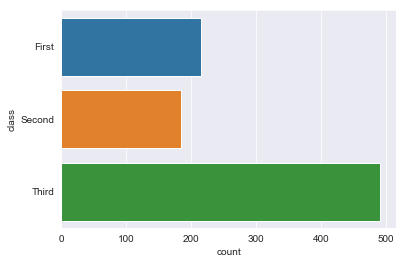

In [9]:
#  A graphical view of the categorical variable "sex"
sns.countplot(data=df, y='class')

C:\Users\J20032\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


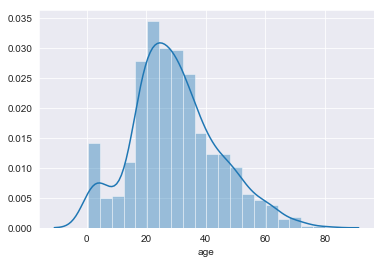

In [10]:
#  Viewing the distribution of a column
sns.distplot(df.age.dropna())

### What is an outlier?

Broadly speaking, an outlier is a value that's so far from normal, it seems more likely to be an abberation in the data as a real value.

Examples:
* Typos (e.g. Height in centimeters of `1611` (just shy of 53 feet tall))
* Truly exceptional performance (that one eBay sale of a 1st Edition Monster Manual just like yours that makes you think you can list it for 2x the average sale price)

#### Identifying and removing outliers

For numerical values that we can treat as normally distributed, we often draw a line around 3-standard deviations.  That is, anything more than 3 standard deviations from the central measure is treated as an outlier.

In [11]:
#  Example:  Finding numerical outliers
s = pd.Series(np.random.normal(size=400))

In [12]:
print("mean:", s.mean(), ", std:", s.std())
outliers = s[np.abs(s - s.mean()) > 3*s.std()]
outliers, outliers.index

mean: 0.001970241456116277 , std: 1.0148542151242408


(241   -3.359227
 dtype: float64, Int64Index([241], dtype='int64'))

In [13]:
#  We can use .drop() with an index to drop specific rows based on their index values.  
#
#  Each series that we create in pandas has an index and can be used this way.
s.drop(outliers.index).shape

(399,)

#### Alternative definition:  1.5 IQR
Seaborn's boxplot uses the concept of 1.5 * IQR outside the middle 50% as the definition of an outlier.

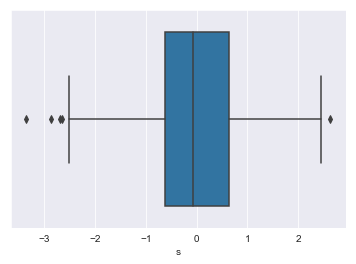

In [14]:
sns.boxplot(data=pd.DataFrame({'s': s}), x='s', whis=1.5)
#  That whis=1.5 is the same 1.5 as in 1.5*IQR

In [15]:
IQR = s.quantile(0.75) - s.quantile(0.25)
outlier_distance = 1.5 * IQR
print("outlier distance = ", outlier_distance)

outlier distance =  1.9077913998375602


In [16]:
#  Filter out anything outside 1.5IQR outside the IQR.
sorted(s[(s > (s.quantile(0.75) + outlier_distance)) | (s < (s.quantile(0.25) - outlier_distance)) ])

[-3.359226945252023,
 -2.8719185835123078,
 -2.6977491284606536,
 -2.658301410537314,
 2.632074822283227]

In [17]:
#  We can separate this out into several expressions if we need to.
low_outliers = (s < (s.quantile(0.25) - outlier_distance))
high_outliers = (s > (s.quantile(0.75) + outlier_distance))
sorted(s[low_outliers | high_outliers])

[-3.359226945252023,
 -2.8719185835123078,
 -2.6977491284606536,
 -2.658301410537314,
 2.632074822283227]

##  Missing values
* How many null values per column? 
* Are there rules that let us guess what they should be (e.g. assume the median)?
  * Consider including a new column indicating whether a value was synthesized for that row

In [18]:
label = ['X', 'O']
df = pd.DataFrame({ 
    'nominal': [label[x] for x in np.random.randint(0, 2, size=5)] + [None, None],
    'numerical': np.random.randint(0, 101, size=5).tolist() + [None, None]
})
df.at[2, 'nominal'] = np.NaN
df.at[3, 'numerical'] = np.NaN
df

,nominal,numerical
0,X,39.0
1,O,51.0
2,NaN,80.0
3,X,NaN
4,X,88.0
5,None,NaN
6,None,NaN


In [19]:
#  Option 1:  dropna
df.dropna()

,nominal,numerical
0,X,39.0
1,O,51.0
4,X,88.0


In [20]:
#  Option 2:  Impute a value using the central statistic 
#  (media, mean, or mode)
df.fillna({ 
    'numerical': df.numerical.median(),
    'nominal': df.nominal.mode()[0]
})

,nominal,numerical
0,X,39.0
1,O,51.0
2,X,80.0
3,X,65.5
4,X,88.0
5,X,65.5
6,X,65.5


Note that imputing is a great example of why documenting your assumptions and choices is so critical: it changes the values in the dataset **based on assumptions that may be untrue**.

## Tidy the Data

* One row per observation, one column per value
* Use `melt`, et al. to transform your data into tidy data.
* Clean and/or parse individual values from columns as needed

## A Process for Tidying

* Start with the rawest data you can find
* Identify which rows you'll drop due to bad data (e.g. nulls, outliers)
* Identify what kinds of transformations you need to get each column to be "sane"
* Use the code to **transform the data into a tidy dataset, from the raw form, in the notebook**
* **Document each column** including whatever information you can find about the column values (e.g how they were collected, what declined-to-answer values look like, etc.)

###  Example:  Cleaning text fields
Sometimes text fields can include data entry issues or other formatting concerns.  In the following example, some of the names have been misspelled using numbers in place of certain letters.  This is sometimes called https://en.m.wikipedia.org/wiki/Leet or "leetspeak".

While it's often done to be obnoxious, using optical character recognition (OCR) can also sometimes confuse letters and numbers, requiring further cleanup.

In [21]:
import pandas as pd
df = pd.DataFrame({'names': ['B0b', 'Joe', 'Ji1l', 'Sally']})

#  Define a helper function to de-leetspeak the text
def de_leetspeak(s):
    return s.replace('0', 'o').replace('1', 'l')

#  Apply it to the column.
df['names'].apply(de_leetspeak)

0      Bob
1      Joe
2     Jill
3    Sally
Name: names, dtype: object

In [22]:
#  We can also filter out rows based on constraints against a column value.
df.names == "B0b"

0     True
1    False
2    False
3    False
Name: names, dtype: bool

In [23]:
#  Or we can "OR" these together using a pipe (|)
(df.names == "B0b") | (df.names == "Joe")

0     True
1     True
2    False
3    False
Name: names, dtype: bool

In [24]:
#  And invert the selection using ~ as an elementwise negation
~((df.names == "B0b") | (df.names == "Joe"))

0    False
1    False
2     True
3     True
Name: names, dtype: bool

In [25]:
#  And we can use these boolean series to index a larger dataframe by row using []
df[~((df.names == "B0b") | (df.names == "Joe"))]

,names
2,Ji1l
3,Sally


###  Example:  Splitting values from one column into multiple new columns

Sometimes data will arrive merged together into a single cell that you wish were actually multiple columns.  A common example of this is dates.

In [26]:
from datetime import datetime, timedelta
df = pd.DataFrame({'date': [(datetime.today() + timedelta(days=d)).isoformat() for d in range(4)]})
df

,date
0,2018-11-04T10:38:33.992585
1,2018-11-05T10:38:33.992585
2,2018-11-06T10:38:33.992585
3,2018-11-07T10:38:33.992585


In [27]:
date_df = df['date'].apply(lambda d: pd.Series(d.split('T')[0].split('-')))
date_df.columns = ['year', 'month', 'day']

pd.concat([df, date_df], axis=1)

,date,year,month,day
0,2018-11-04T10:38:33.992585,2018,11,04
1,2018-11-05T10:38:33.992585,2018,11,05
2,2018-11-06T10:38:33.992585,2018,11,06
3,2018-11-07T10:38:33.992585,2018,11,07


##  From long to wide (pivot) and wide to long (melt)

As we discussed regarding "tidy data", there are two forms:
* wide - where each attribute gets its own column
* long - where each $(value, attribute)$ pair gets its own row

In [28]:
#  This example creates a long-form dataset with some built-in pandas fu.  You do not need to know how this works
#  for this class.
#
#  from:  https://pandas.pydata.org/pandas-docs/stable/reshaping.html
import pandas.util.testing as tm; tm.N = 3
def unpivot(frame):
    N, K = frame.shape
    data = {'value' : frame.values.ravel('F'),
            'variable' : np.asarray(frame.columns).repeat(N),
            'date' : np.tile(np.asarray(frame.index), K)}
    return pd.DataFrame(data, columns=['date', 'variable', 'value'])
long_df = unpivot(tm.makeTimeDataFrame())

In [29]:
long_df

,date,variable,value
0,2000-01-03,A,1.114496
1,2000-01-04,A,1.706916
2,2000-01-05,A,0.890784
3,2000-01-03,B,-0.162416
4,2000-01-04,B,2.296278
5,2000-01-05,B,-0.738812
6,2000-01-03,C,1.068308
7,2000-01-04,C,0.538516
8,2000-01-05,C,1.187175
9,2000-01-03,D,-0.369108


In [30]:
wide_df = df.pivot(index="date", columns="variable", values="value")
wide_df

KeyError: 'variable'

In [ ]:
wide_df.reset_index().melt(id_vars=['date'])